<a href="https://colab.research.google.com/github/JorgeAccardi/auscultacion-presa/blob/main/Aus_Inclinometro_GKN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import os

def procesar_gkn_inclinometros(file_path):
    try:
        print(f"Procesando el archivo: {file_path}")
        with open(file_path, 'r') as file:
            lines = file.readlines()
            fecha = next((line.split(":")[1].strip() for line in lines if line.startswith("DATE")), None)
            nro_sonda = next((line.split(":")[1].strip() for line in lines if line.startswith("PROBE NO.")), None)
            hole_no = next((line.split(":")[1].strip() for line in lines if line.startswith("HOLE NO.")), None)
            start_idx = next((i + 2 for i, line in enumerate(lines) if '#READINGS:' in line), None)
            if start_idx is None:
                raise ValueError(f"No se encontraron lecturas en el archivo {file_path}")
            data = [line.strip().split(',') for line in lines[start_idx:]]
            df = pd.DataFrame(data, columns=['Profundidad', 'A+', 'A-', 'B+', 'B-'])
            df = df.apply(pd.to_numeric, errors='coerce')
            df['Fecha'] = pd.to_datetime(fecha, dayfirst=True, errors='coerce').strftime('%d/%m/%Y')
            df['Inclinómetro'] = hole_no
            df['Nro. Sonda'] = nro_sonda
            df = df[['Fecha', 'Inclinómetro', 'Profundidad', 'A+', 'A-', 'B+', 'B-', 'Nro. Sonda']]
            print(f"Archivo procesado correctamente: {file_path}")
            return df
    except Exception as e:
        print(f"Error procesando el archivo {file_path}: {e}")
        return None

def procesar_varios_gkn(file_list):
    dfs = []
    for file_path in file_list:
        df = procesar_gkn_inclinometros(file_path)
        if df is not None:
            dfs.append(df)
    if dfs:
        df_final = pd.concat(dfs, ignore_index=True)
        print("Todos los archivos fueron procesados correctamente.")
        return df_final
    else:
        print("No se pudieron procesar los archivos.")
        return None

In [12]:
import os
from google.colab import files

def seleccionar_fuente_gkn():
    print("Selecciona la fuente de tus archivos GKN:")
    print("1 - Subir ZIP con todos los archivos desde tu computadora")
    print("2 - Carpeta en Google Drive")
    print("3 - Carpeta en /content de Colab")
    print("4 - Seleccionar carpeta localmente (visual, solo en Colab)")
    fuente = input("Escribe 1, 2, 3 o 4 y presiona ENTER: ")
    return fuente.strip()

file_names = []
fuente = seleccionar_fuente_gkn()

if fuente == "1":
    print("Sube el archivo .zip que contiene todos los archivos GKN:")
    uploaded = files.upload()
    import zipfile
    for filename in uploaded.keys():
        if filename.endswith('.zip'):
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall('GKN_folder')
            print("ZIP descomprimido en /content/GKN_folder")
        else:
            print("El archivo subido no es un .zip")
    carpeta_gkn = '/content/GKN_folder'
    file_names = [os.path.join(carpeta_gkn, f) for f in os.listdir(carpeta_gkn) if f.lower().endswith('.gkn')]
    print("Archivos GKN encontrados:", file_names)

elif fuente == "2":
    from google.colab import drive
    drive.mount('/content/drive')
    carpeta_gkn = input("Pega la ruta completa de la carpeta en Google Drive (ej: /content/drive/MyDrive/MisGKN): ").strip()
    if not os.path.exists(carpeta_gkn):
        raise ValueError("La carpeta especificada no existe.")
    file_names = [os.path.join(carpeta_gkn, f) for f in os.listdir(carpeta_gkn) if f.lower().endswith('.gkn')]
    print("Archivos GKN encontrados:", file_names)

elif fuente == "3":
    carpeta_gkn = input("Pega la ruta de la carpeta en /content (ej: /content/GKN): ").strip()
    if not os.path.exists(carpeta_gkn):
        raise ValueError("La carpeta especificada no existe.")
    file_names = [os.path.join(carpeta_gkn, f) for f in os.listdir(carpeta_gkn) if f.lower().endswith('.gkn')]
    print("Archivos GKN encontrados:", file_names)

elif fuente == "4":
    try:
        from google.colab import widgets
        import shutil
        print("Selecciona la carpeta con los archivos GKN en tu computadora.")
        # Usar el selector visual
        folder_uploaded = files.upload()
        local_folder = '/content/selected_folder'
        os.makedirs(local_folder, exist_ok=True)
        # Mueve los archivos subidos a una carpeta
        for filename in folder_uploaded.keys():
            shutil.move(filename, os.path.join(local_folder, filename))
        file_names = [os.path.join(local_folder, f) for f in os.listdir(local_folder) if f.lower().endswith('.gkn')]
        print("Archivos GKN encontrados:", file_names)
    except Exception as e:
        print("Funcionalidad visual de carpeta local no disponible. Usa ZIP o Drive para carpetas masivas.")
        file_names = []

else:
    print("Opción no válida. Ejecuta la celda de nuevo y elige 1, 2, 3 o 4.")

# Procesar todos los archivos encontrados (si hay)
if file_names:
    df_gkn = procesar_varios_gkn(file_names)
    if df_gkn is not None:
        display(df_gkn.head())
else:
    print("No se encontraron archivos para procesar.")

Selecciona la fuente de tus archivos GKN:
1 - Subir ZIP con todos los archivos desde tu computadora
2 - Carpeta en Google Drive
3 - Carpeta en /content de Colab
4 - Seleccionar carpeta localmente (visual, solo en Colab)
Escribe 1, 2, 3 o 4 y presiona ENTER: 4
Selecciona la carpeta con los archivos GKN en tu computadora.


Saving MD-IN1-150_001.gkn to MD-IN1-150_001 (2).gkn
Saving MD-IN1-150_002.gkn to MD-IN1-150_002 (2).gkn
Saving MD-IN1-150_003.gkn to MD-IN1-150_003 (2).gkn
Saving MD-IN1-150_004.gkn to MD-IN1-150_004 (2).gkn
Saving MD-IN1-150_005.gkn to MD-IN1-150_005 (2).gkn
Saving MD-IN1-150_006.gkn to MD-IN1-150_006 (2).gkn
Saving MD-IN1-150_007.gkn to MD-IN1-150_007 (2).gkn
Saving MD-IN1-150_008.gkn to MD-IN1-150_008 (2).gkn
Saving MD-IN1-150_009.gkn to MD-IN1-150_009 (2).gkn
Saving MD-IN1-150_010.gkn to MD-IN1-150_010 (2).gkn
Saving MD-IN1-150_011.gkn to MD-IN1-150_011 (2).gkn
Saving MD-IN1-150_012.gkn to MD-IN1-150_012 (2).gkn
Saving MD-IN1-150_012_Compass.GKS to MD-IN1-150_012_Compass (1).GKS
Saving MD-IN1-150_013.gkn to MD-IN1-150_013 (2).gkn
Saving MD-IN1-150_014.gkn to MD-IN1-150_014 (2).gkn
Saving MD-IN1-150_015.gkn to MD-IN1-150_015 (2).gkn
Saving MD-IN1-150_016.gkn to MD-IN1-150_016 (2).gkn
Saving MD-IN1-150_017.gkn to MD-IN1-150_017 (2).gkn
Saving MD-IN1-150_018.gkn to MD-IN1-150_018 (2).

,Fecha,Inclinómetro,Profundidad,A+,A-,B+,B-,Nro. Sonda
0,29/06/2022,MD-IN1-150,55.5,970,-994,-14,105,Probe-93
1,29/06/2022,MD-IN1-150,55.0,968,-983,-15,110,Probe-93
2,29/06/2022,MD-IN1-150,54.5,960,-976,-14,110,Probe-93
3,29/06/2022,MD-IN1-150,54.0,975,-992,-7,98,Probe-93
4,29/06/2022,MD-IN1-150,53.5,982,-996,5,90,Probe-93


In [15]:
from google.colab import files
import os

print("¿Dónde quieres guardar los archivos?")
print("1 - Descargar a mi computadora (PC)")
print("2 - Guardar en /content de Colab")
print("3 - Guardar en mi Google Drive")
opcion = input("Elige 1, 2 o 3: ").strip()

if 'df_gkn' in locals() and df_gkn is not None and not df_gkn.empty:
    nombres_inclinometro = df_gkn['Inclinómetro'].unique()
    print(f"Se encontraron los siguientes inclinómetros: {nombres_inclinometro}")
    rutas_guardadas = []
    for nombre in nombres_inclinometro:
        df_sel = df_gkn[df_gkn['Inclinómetro'] == nombre]
        base_nombre = f"inclinometro_{str(nombre).replace(' ','_').replace('/','-')}"
        archivo_xlsx = f"{base_nombre}.xlsx"
        archivo_csv = f"{base_nombre}.csv"

        if opcion == "1":
            # Guardar temporalmente en /content y descargar
            df_sel.to_excel(archivo_xlsx, index=False)
            df_sel.to_csv(archivo_csv, index=False)
            print(f"Descargando: {archivo_xlsx} y {archivo_csv}")
            files.download(archivo_xlsx)
            files.download(archivo_csv)
            rutas_guardadas.extend([archivo_xlsx, archivo_csv])

        elif opcion == "2":
            # Guardar solo en /content
            df_sel.to_excel(f"/content/{archivo_xlsx}", index=False)
            df_sel.to_csv(f"/content/{archivo_csv}", index=False)
            print(f"Guardado en /content: {archivo_xlsx} y {archivo_csv}")
            rutas_guardadas.extend([f"/content/{archivo_xlsx}", f"/content/{archivo_csv}"])

        elif opcion == "3":
            # Guardar en Google Drive (asegúrate de tener Drive montado)
            from google.colab import drive
            drive.mount('/content/drive', force_remount=True)
            ruta_drive = input("Escribe la ruta completa en tu Drive donde guardar los archivos (ej: /content/drive/MyDrive/MisGKN): ").strip()
            os.makedirs(ruta_drive, exist_ok=True)
            ruta_xlsx = os.path.join(ruta_drive, archivo_xlsx)
            ruta_csv = os.path.join(ruta_drive, archivo_csv)
            df_sel.to_excel(ruta_xlsx, index=False)
            df_sel.to_csv(ruta_csv, index=False)
            print(f"Guardado en Drive: {ruta_xlsx} y {ruta_csv}")
            rutas_guardadas.extend([ruta_xlsx, ruta_csv])

        else:
            print("Opción no válida.")
            break

    print("Archivos generados:", rutas_guardadas)
else:
    print("No hay datos procesados para guardar.")

¿Dónde quieres guardar los archivos?
1 - Descargar a mi computadora (PC)
2 - Guardar en /content de Colab
3 - Guardar en mi Google Drive
Elige 1, 2 o 3: 2
Se encontraron los siguientes inclinómetros: ['MD-IN1-150']
Guardado en /content: inclinometro_MD-IN1-150.xlsx y inclinometro_MD-IN1-150.csv
Archivos generados: ['/content/inclinometro_MD-IN1-150.xlsx', '/content/inclinometro_MD-IN1-150.csv']


# Paso 4: ETL y Análisis Exploratorio de Datos de Inclinómetros

Este paso realiza un análisis ETL típico sobre el DataFrame procesado:

- **Extracción:** Usa el DataFrame obtenido previamente.
- **Transformación:**
  - Elimina duplicados y nulos.
  - Convierte tipos de datos.
  - Genera estadísticas descriptivas.
  - Normaliza variables de lectura.
  - Detecta valores atípicos (outliers) usando Z-score.
  - Agrupa por inclinómetro y fecha para obtener resúmenes.
- **Carga:** Exporta el DataFrame transformado a CSV y Excel.

Puedes adaptar los pasos de transformación según tu análisis específico (por ejemplo, agregar análisis de tendencias, visualizaciones, etc.).

---

In [16]:
# PASO 4: Análisis ETL completo sobre el DataFrame de inclinómetros
#
# Este bloque realiza un proceso ETL típico:
# - Extracción: Ya obtuviste el DataFrame df_gkn en pasos anteriores.
# - Transformación: Limpieza, tipos de datos, normalización, análisis estadísticos y detección de outliers.
# - Carga: Visualización y exportación del resultado transformado.
#
# Puedes modificar los pasos según tu necesidad.

import pandas as pd
import numpy as np

# --- EXTRACT ---
# df_gkn ya debería estar cargado. Si no, carga tu archivo aquí.
# df_gkn = pd.read_excel('mi_archivo.xlsx')  # Descomenta si necesitas cargar manualmente

# --- TRANSFORM ---

print("1. Información general del DataFrame:")
print(df_gkn.info())
display(df_gkn.head())

print("\n2. Eliminar duplicados...")
df_gkn = df_gkn.drop_duplicates()
print("Filas tras eliminar duplicados:", len(df_gkn))

print("\n3. Comprobar valores nulos por columna:")
print(df_gkn.isnull().sum())

print("\n4. Rellenar o eliminar nulos...")
# Ejemplo: rellenar nulos en 'Nro. Sonda' con 'Desconocido'
df_gkn['Nro. Sonda'] = df_gkn['Nro. Sonda'].fillna('Desconocido')
# Opcional: eliminar filas con muchos nulos
df_gkn = df_gkn.dropna(subset=['Profundidad', 'A+', 'A-', 'B+', 'B-'])

print("\n5. Conversión de tipos:")
df_gkn['Fecha'] = pd.to_datetime(df_gkn['Fecha'], dayfirst=True, errors='coerce')
for col in ['Profundidad', 'A+', 'A-', 'B+', 'B-']:
    df_gkn[col] = pd.to_numeric(df_gkn[col], errors='coerce')

print("\n6. Resumen estadístico:")
display(df_gkn.describe())

print("\n7. Normalización (opcional, crea columnas '_norm'):")
for col in ['A+', 'A-', 'B+', 'B-']:
    col_norm = col + '_norm'
    df_gkn[col_norm] = (df_gkn[col] - df_gkn[col].mean()) / df_gkn[col].std()

print("\n8. Detección de valores atípicos (outliers) en A+, A-, B+, B- (Z-score > 3):")
for col in ['A+', 'A-', 'B+', 'B-']:
    z_score = np.abs((df_gkn[col] - df_gkn[col].mean()) / df_gkn[col].std())
    outliers = df_gkn[z_score > 3]
    print(f"{col}: {len(outliers)} outliers")
    if not outliers.empty:
        display(outliers[['Fecha', 'Inclinómetro', 'Profundidad', col]])

print("\n9. Agrupar por inclinómetro y fecha, obtener estadísticas:")
agrupado = df_gkn.groupby(['Inclinómetro', 'Fecha']).agg(
    {'Profundidad':'count', 'A+':'mean', 'A-':'mean', 'B+':'mean', 'B-':'mean'}
).rename(columns={'Profundidad':'Lecturas'}).reset_index()
display(agrupado)

print("\n10. Guardar el DataFrame transformado (opcional):")
df_gkn.to_csv('gkn_etl_transformado.csv', index=False)
df_gkn.to_excel('gkn_etl_transformado.xlsx', index=False)
print("Archivos guardados: gkn_etl_transformado.csv y gkn_etl_transformado.xlsx")

# Puedes descargar con:
# from google.colab import files
# files.download('gkn_etl_transformado.csv')
# files.download('gkn_etl_transformado.xlsx')

1. Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330 entries, 0 to 3329
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Fecha         3330 non-null   object 
 1   Inclinómetro  3330 non-null   object 
 2   Profundidad   3330 non-null   float64
 3   A+            3330 non-null   int64  
 4   A-            3330 non-null   int64  
 5   B+            3330 non-null   int64  
 6   B-            3330 non-null   int64  
 7   Nro. Sonda    3330 non-null   object 
dtypes: float64(1), int64(4), object(3)
memory usage: 208.3+ KB
None


,Fecha,Inclinómetro,Profundidad,A+,A-,B+,B-,Nro. Sonda
0,29/06/2022,MD-IN1-150,55.5,970,-994,-14,105,Probe-93
1,29/06/2022,MD-IN1-150,55.0,968,-983,-15,110,Probe-93
2,29/06/2022,MD-IN1-150,54.5,960,-976,-14,110,Probe-93
3,29/06/2022,MD-IN1-150,54.0,975,-992,-7,98,Probe-93
4,29/06/2022,MD-IN1-150,53.5,982,-996,5,90,Probe-93



2. Eliminar duplicados...
Filas tras eliminar duplicados: 3330

3. Comprobar valores nulos por columna:
Fecha           0
Inclinómetro    0
Profundidad     0
A+              0
A-              0
B+              0
B-              0
Nro. Sonda      0
dtype: int64

4. Rellenar o eliminar nulos...

5. Conversión de tipos:

6. Resumen estadístico:


,Fecha,Profundidad,A+,A-,B+,B-
count,3330,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000
mean,2023-03-02 16:48:00,28.000000,655.319219,-659.344444,-1.384384,81.505105
min,2022-06-29 00:00:00,0.500000,176.000000,-1034.000000,-285.000000,-166.000000
25%,2022-08-15 00:00:00,14.000000,465.000000,-908.000000,-89.000000,-43.000000
50%,2023-04-15 00:00:00,28.000000,715.000000,-719.000000,-25.000000,108.000000
75%,2023-07-25 00:00:00,42.000000,904.000000,-471.000000,126.000000,169.000000
max,2023-11-18 00:00:00,55.500000,1030.000000,-186.000000,245.000000,354.000000
std,NaN,16.023226,257.020437,256.883942,131.106287,130.195322



7. Normalización (opcional, crea columnas '_norm'):

8. Detección de valores atípicos (outliers) en A+, A-, B+, B- (Z-score > 3):
A+: 0 outliers
A-: 0 outliers
B+: 0 outliers
B-: 0 outliers

9. Agrupar por inclinómetro y fecha, obtener estadísticas:


,Inclinómetro,Fecha,Lecturas,A+,A-,B+,B-
0,MD-IN1-150,2022-06-29,111,646.720721,-663.684685,7.081081,83.693694
1,MD-IN1-150,2022-07-02,111,645.612613,-665.387387,6.126126,83.585586
2,MD-IN1-150,2022-07-08,111,646.954955,-663.729730,4.504505,87.126126
3,MD-IN1-150,2022-07-11,111,645.135135,-665.432432,1.900901,83.747748
4,MD-IN1-150,2022-07-15,111,646.540541,-664.153153,6.855856,83.549550
5,MD-IN1-150,2022-08-03,111,646.522523,-663.675676,2.162162,87.909910
6,MD-IN1-150,2022-08-07,111,644.315315,-666.000000,6.819820,83.711712
7,MD-IN1-150,2022-08-15,111,650.441441,-661.144144,19.666667,95.558559
8,MD-IN1-150,2022-08-19,111,647.648649,-662.648649,17.414414,99.018018
9,MD-IN1-150,2022-08-26,111,648.027027,-663.144144,16.198198,100.126126



10. Guardar el DataFrame transformado (opcional):
Archivos guardados: gkn_etl_transformado.csv y gkn_etl_transformado.xlsx


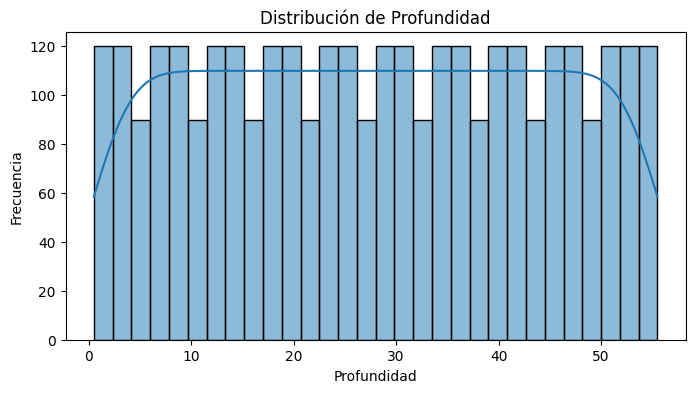

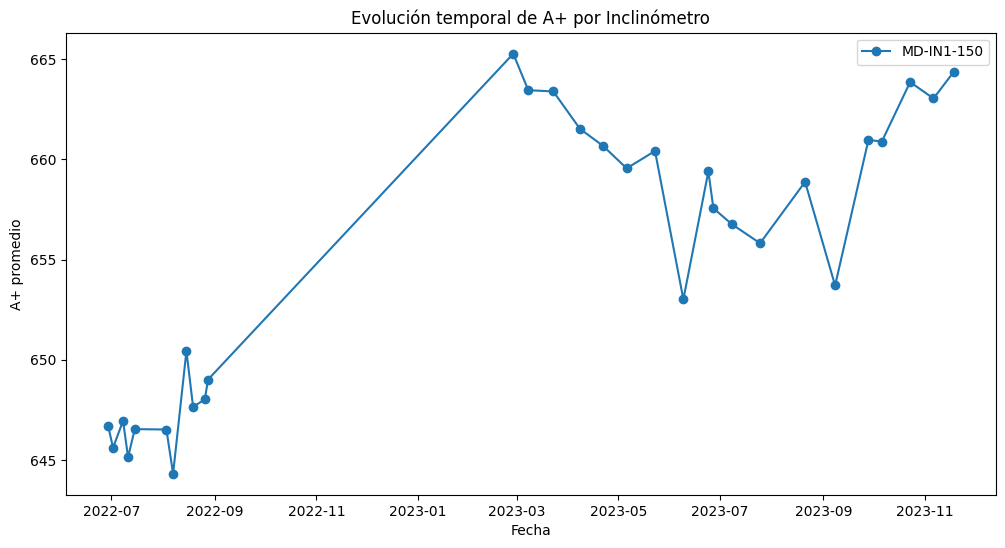

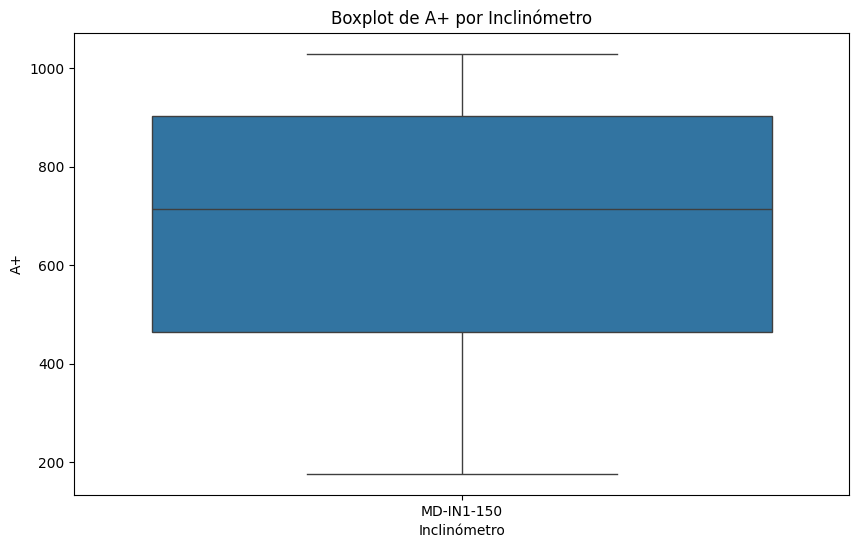

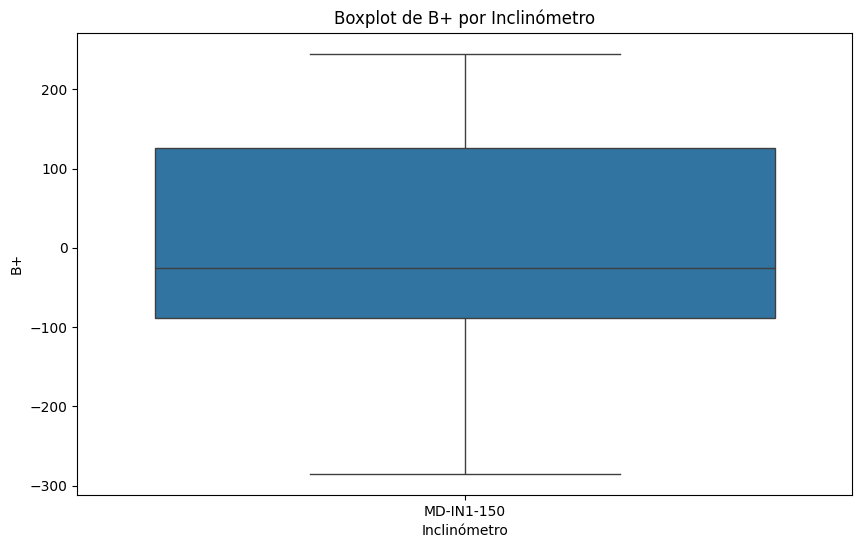

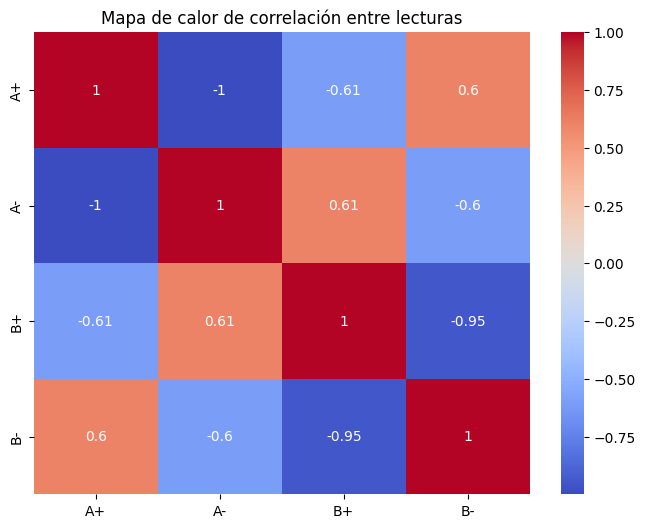

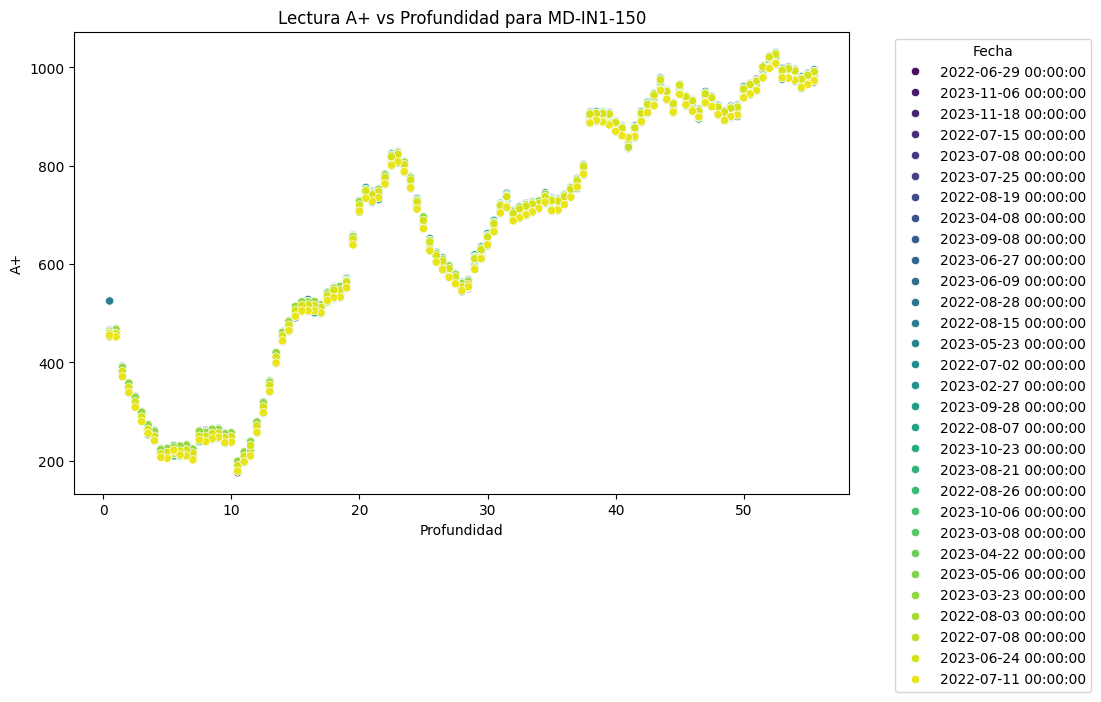

In [17]:
# PASO 5: Visualizaciones exploratorias del DataFrame de inclinómetros
#
# Esta celda genera gráficos para analizar visualmente el comportamiento de los datos.
# Puedes agregar o modificar visualizaciones según tu necesidad.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asegura que la fecha sea tipo datetime
df_gkn['Fecha'] = pd.to_datetime(df_gkn['Fecha'], errors='coerce')

# 1. Distribución de profundidades medidas
plt.figure(figsize=(8,4))
sns.histplot(df_gkn['Profundidad'], bins=30, kde=True)
plt.title('Distribución de Profundidad')
plt.xlabel('Profundidad')
plt.ylabel('Frecuencia')
plt.show()

# 2. Evolución temporal de A+ por inclinómetro
plt.figure(figsize=(12,6))
for nombre in df_gkn['Inclinómetro'].unique():
    datos = df_gkn[df_gkn['Inclinómetro'] == nombre]
    datos_agr = datos.groupby('Fecha')['A+'].mean().reset_index()
    plt.plot(datos_agr['Fecha'], datos_agr['A+'], marker='o', label=str(nombre))
plt.title('Evolución temporal de A+ por Inclinómetro')
plt.xlabel('Fecha')
plt.ylabel('A+ promedio')
plt.legend()
plt.show()

# 3. Boxplot de lecturas para detectar outliers por sensor y canal
plt.figure(figsize=(10,6))
sns.boxplot(x='Inclinómetro', y='A+', data=df_gkn)
plt.title('Boxplot de A+ por Inclinómetro')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='Inclinómetro', y='B+', data=df_gkn)
plt.title('Boxplot de B+ por Inclinómetro')
plt.show()

# 4. Mapa de calor de correlación entre canales
plt.figure(figsize=(8,6))
sns.heatmap(df_gkn[['A+','A-','B+','B-']].corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de calor de correlación entre lecturas')
plt.show()

# 5. Lecturas en función de la profundidad para un inclinómetro seleccionado
inclino = df_gkn['Inclinómetro'].unique()[0]
df_filtro = df_gkn[df_gkn['Inclinómetro'] == inclino]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Profundidad', y='A+', data=df_filtro, hue='Fecha', palette='viridis')
plt.title(f'Lectura A+ vs Profundidad para {inclino}')
plt.xlabel('Profundidad')
plt.ylabel('A+')
plt.legend(title='Fecha', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Puedes agregar más gráficos (tendencias, series de tiempo, etc.) según tus necesidades.